### 一連の流れ
* データセットの中から、すべて０なデータを省き、log10にした
* 正規化をした-> 標準化とどっちが良いのだろうか？
* PCAを行い次元削除の結果、次元を4096->1500にした。(次元削除は次元が高く、データ数が少ないと過学習を起こすためそれを防ぐ？)
* GridSearchによるパラメータチューニング
    - Classification
        - Linear
        - SGD
    - Clustering
        - Kmeans(<10,000)
        - Minibathc(>10,000)

* 交差検証によって、評価した？

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
#import mglearn
import copy

from select_datasets import Select_datasets as my_SD
from visualize import visualization
myvs = visualization()
from select_datasets import Select_datasets as my_SD
myds = my_SD("/data7/ALL/db/ns/8k")
from sklearn.preprocessing import StandardScaler


In [2]:
# Constant

f_s = 12.5*10**3
th_s = 2
N = 4096
pixel_number=36

f_range = f_s/th_s
f_resolution = f_range/N

x = np.arange(1,4097)*f_resolution

## データの可視化

# 教師あり学習

## データセット選択

- 36*3168?のデータを読み込み

In [12]:
# normal データ
data_df = myds.concat_npz()

In [13]:
data_df_pre = data_df[(data_df < 10**10).all(axis=1)]
data_df_pre.replace(0, np.nan, inplace=True)
data_df_pre=data_df_pre.dropna(axis=0,how="all")
data_df_pre=data_df_pre.fillna(method="ffill")
data_df_pre

/usr/local/conda/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0           1           2           3           4     \
3       172.896067  176.513317  251.178517  237.754544  296.303427   
4        75.659870  120.790621  169.793157  125.246630  179.171441   
5        96.913210  113.915134  121.180175  122.038119  161.548251   
6       126.852502  116.382145  156.818553  166.869081  215.471876   
7       152.509383   80.845047  142.408379  100.871204  170.583987   
...            ...         ...         ...         ...         ...   
121206  122.093491  116.433336  145.048783  114.312061  192.500221   
121207  104.721016  133.593078  151.468548  248.887670  189.338949   
121208   46.706180  152.973006  166.045044  166.933334  203.486829   
121209  105.969081  152.464743  240.822518  264.686312  293.389996   
121211  144.451794   98.450465  165.335247  225.233102  234.669472   

              5           6           7           8           9     ...  \
3       458.932187  292.656312  307.286854  387.060255  316.580215  ...   
4       172.916762  365.257365  228.995861  334.066903  332.763197  ...   
5       175.660607  169.937570  264.225008  296.083163  214.468419  ...   
6       246.746340  190.952035  221.437342  354.225474  365.486685  ...   
7       265.994181  350.298726  220.398215  326.459230  378.799860  ...   
...            ...         ...         ...         ...         ...  ...   
121206  288.475542  235.521077  326.818310  325.784505  413.378888  ...   
121207  276.713913  191.168293  400.484528  327.071259  432.536595  ...   
121208  321.153870  251.722031  296.447174  325.160645  502.389947  ...   
121209  274.296324  175.683277  307.671430  405.552416  286.639501  ...   
121211  219.059660  341.781429  401.365567  312.127433  442.259728  ...   

             4086       4087       4088       4089       4090       4091  \
3       57.880442  62.912938  61.179425  64.074222  55.001100  52.704118   
4       46.919632  42.056913  51.594663  43.388040  65.149759  58.103191   
5       31.654877  63.428767  53.975433  60.945989  64.399889  63.978724   
6       37.194936  39.683748  36.201481  44.939306  44.346538  62.125257   
7       42.044070  74.023168  42.561793  54.074173  57.641413  60.351826   
...           ...        ...        ...        ...        ...        ...   
121206  36.490726  67.808725  48.635387  50.200662  51.017458  59.866099   
121207  42.375570  81.769752  45.345539  43.448880  82.272236  63.297307   
121208  41.353307  63.355435  54.759350  62.044661  47.635674  40.809098   
121209  51.146510  41.702423  56.276364  60.299632  73.716034  43.376745   
121211  44.240792  52.671475  49.086312  73.474214  31.026711  31.779970   

              4092       4093       4094       4095  
3        39.206178  51.482939  46.324574  60.375492  
4        50.641018  52.523666  46.103034  37.973675  
5        54.476862  56.281915  55.273729  36.780430  
6        86.734242  54.187370  57.170438  88.911192  
7        73.458150  59.508927  42.959056  61.247041  
...            ...        ...        ...        ...  
121206   53.224668  57.230263  69.116797  42.033320  
121207   48.176307  69.086240  53.447849  72.262023  
121208   55.403104  49.697371  61.116719  67.944095  
121209  100.411410  48.000557  59.768421  41.366653  
121211   50.066673  49.383770  53.873452  73.684462  

[103608 rows x 4096 columns]

In [14]:
X = np.log10(data_df_pre.to_numpy())
y = list(data_df_pre.index%pixel_number)

## 次元削除

### PCA

- 4096　次元を 25次元にした。
- 25の理由は、寄与率が9割超しているからである

In [91]:
from sklearn.decomposition import PCA

In [92]:
n_com = 25

In [93]:
pca = PCA(n_components=n_com)
pca.fit(X)
X_pca = pca.transform(X)

In [75]:
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0],X_pca[:,1],y)
plt.xlim(0,1)
plt.legend(y,loc="best")

NameError: name 'mglearn' is not defined

<Figure size 800x800 with 0 Axes>

In [ ]:
fig,ax = plt.subplots(constrained_layout = True)
ax.plot(range(n_com),np.cumsum(pca.explained_variance_ratio_))
ax.scatter(range(n_com),np.cumsum(pca.explained_variance_ratio_))
ax.grid()
ax.set_xlabel("component")
ax.set_ylabel("Contribution rate")

#### PCAの可視化

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(13,4))

f_l = np.arange(len(pca.components_[0]))+1

ax[0].scatter(f_l*f_resolution,pca.components_[0])
ax[1].scatter(f_l*f_resolution,pca.components_[1])
ax[0].set_xticks(f_l*f_resolution)
ax[0].grid()
ax[1].set_xticks(f_l*f_resolution)
ax[1].grid()

In [ ]:
fig,ax = plt.subplots()
f_l = np.arange(len(pca.components_[0]))+1
ax.scatter(f_l*f_resolution,pca.components_[0])
ax.set_xscale("log")
ax.set_xlabel("freqency")
ax.set_ylabel("value")

In [ ]:
fig,ax = plt.subplots()
f_l = np.arange(len(pca.components_[0]))+1
ax.scatter(f_l*f_resolution,pca.components_[0])

ax.set_xlabel("freqency")
ax.set_ylabel("value")
ax.set_xlim([3000,f_range])

In [ ]:
np_point = np.array(pca.components_[0])
np_f = np.array(f_l)
np_f=np_f[np_point>0.03]
np_f

In [ ]:
np_point_ = np.array(pca.components_[0])
np_f = np.array(f_l)
np_f_g = np.array(f_l)
np_f= np_f[np_point_>0.03]
np_f_g = np_f_g[np_point_>0.01]

path="/data7/ALL/db/ns/8k"
npz_files = glob.glob(path+"/**.npz")

d = np.load(npz_files[0])

fig,ax = plt.subplots(constrained_layout=True)

f=np.linspace(0,f_range,N)
f_=np_f*f_resolution
f_g = np_f_g*f_resolution

for pixel in range(0,pixel_number):
    ax.plot(f,df[pixel])

for pixel in range(0,pixel_number):
    np_g = np.array(pd.DataFrame(d["arr_0"])[pixel])
    np_g = np_g[np_point_>0.01]
    ax.plot(f_g,np_g,color="gray",label="more than 0.01")

for pixel in range(0,pixel_number):
    np_ = np.array(pd.DataFrame(d["arr_0"])[pixel])
    np_ = np_[np_point_>0.03]
    ax.plot(f_,np_,color="black",label="more than 0.03")
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1,f_range])
ax.set_xlabel("frequency")
ax.set_ylabel("power")
#ax.legend()

In [ ]:
fig,ax = plt.subplots()
f_l = np.arange(len(pca.components_[1]))+1
ax.scatter(f_l*f_resolution,pca.components_[1])
ax.set_xscale("log")
ax.set_xlabel("freqency")
ax.set_ylabel("value")

In [ ]:
np_point_ = np.array(pca.components_[1])
np_f = np.array(f_l)
np_f_g = np.array(f_l)
np_f= np_f[np_point_>0.03]
np_f_g = np_f_g[np_point_>0.01]

path="/data7/ALL/db/ns/8k"
npz_files = glob.glob(path+"/**.npz")

d = np.load(npz_files[0])

fig,ax = plt.subplots(constrained_layout=True)

f=np.linspace(0,f_range,N)
f_=np_f*f_resolution
f_g = np_f_g*f_resolution

for pixel in range(0,pixel_number):
    ax.plot(f,df[pixel],label=f"pixel={pixel}")



for pixel in range(0,pixel_number):
    np_g = np.array(pd.DataFrame(d["arr_0"])[pixel])
    np_g = np_g[np_point_>0.01]
    ax.plot(f_g,np_g,label=f"pixel={pixel}",color="gray")

for pixel in range(0,pixel_number):
    np_ = np.array(pd.DataFrame(data["arr_0"])[pixel])
    np_ = np_[np_point_>0.03]
    ax.plot(f_,np_,label=f"pixel={pixel}",color="black")
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1,f_range])
ax.set_xlabel("frequency")
ax.set_ylabel("power")

### T-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(random_state=0)
X_tsne = tsne.fit_transform(pd.DataFrame(X_std))

In [ ]:
"""
end = 100
for i in range(end):
    plt.text(X_tsne[i,0],X_tsne[i,0],str(y[i]))

"""

## 標準化

- SGD Classifier Linear SVC は標準化もしくは正規化をしておくとよい

In [94]:
from sklearn.preprocessing import StandardScaler

In [95]:
sc = StandardScaler()
sc.fit(X_pca)
X_pca_std = sc.transform(X_pca)

## parameter tuning 

- LinearSVC 25*10< 20,000 * 0.7 データでパラメータチューニングを行った
- SGD Classifierでは100,000 * 0.7で行った

In [58]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

#### LinerSVC

In [60]:
X_train,X_test,y_train,y_test = train_test_split(X_pca,y,test_size = 0.3,random_state=0)
X_train_grid,X_train_cross,y_train_grid,y_train_cross = train_test_split(X_train,y_train,random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)

sc = StandardScaler()
sc.fit(X_test)
X_test_std = sc.transform(X_test)

In [23]:
parameters = {
    "loss":["hinge","squared_hinge"],
    "C":[1,0.1,0.01,0.001]
    }

lsvc = LinearSVC(random_state=0,dual=False,penalty="l2")

L_grid = GridSearchCV(lsvc,parameters,cv=3)

L_grid.fit(X_train_grid,y_train_grid)

print(L_grid.best_params_)

/usr/local/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/conda/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 238, in fit
    self.loss, sample_weight=sample_weight)
  File "/usr/local/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/usr/local/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 832, in _get_liblinear_solver_type
    % (error_string, penalty, loss, dual))
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' a

KeyboardInterrupt: 

#### SGDClassifier

In [ ]:
n = len(X_train_grid)
np.ceil(10**6 / n)

In [ ]:
parameters = {
    "verbose":[0,1,10,100],
    "eta0":[0,10],
    "average":[1,10,100]
    }
    

sgd = SGDClassifier(random_state=0,max_iter=14,penalty="l2",alpha=10**-6,loss="squared_hinge")

S_grid = GridSearchCV(sgd,parameters,cv=3)

S_grid.fit(X_train_grid,y_train_grid)

print(S_grid.best_params_)

## 交差検証

- LinearSVC(14,000sample)とSGD(70,000sample)のどれが一番性能が良いかを調べた。
- 多分100,000が一番だと思うが、データ数が多いので、14,000サンプルでやった二つのどちらかとそこまで変わらなければ、そちらを採用したい。

- 公式のドキュメントをみたらL2ノルムを１にするようにデータセットをやると、SGDではよいと言ってた。それも試したいが、どのようにしよう

- ちがう

In [ ]:
from sklearn.model_selection import cross_val_score

#### LinearSVC

In [ ]:
lsvc = LinearSVC(
    random_state=0,
    dual=False,
    penalty="l2",
    loss='squared_hinge',
    C=1
    )

l_score = cross_val_score(sgd,X_train_cross,y_train_cross,cv=5)

print(l_score)

In [ ]:
l_score.mean()

#### SGD

In [ ]:
sgd = SGDClassifier(
    random_state=0,
    max_iter=14,
    alpha=0.000001,
    loss='squared_hinge',
    penalty="l2",
    average=1,
    eta0= 0,
    verbose= 0
    )

s_scores = cross_val_score(sgd,X_train_cross,y_train_cross,cv=5)

print(s_scores)

In [ ]:
s_scores.mean()


第０、第一コンポーネントの視覚化

## 結果

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [23]:
sgd = SGDClassifier(alpha=0.0001,loss="log",penalty="l2")
sgd.fit(X_train,y_train)

y_pred = sgd.predict(X_test)
m = confusion_matrix(y_test,y_pred)
print(m)

/home/kashiwazaki/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


[[867   0   0 ...   0   0   0]
 [  0 802   0 ...   0   0   0]
 [  0   0 834 ...   0   0   0]
 ...
 [  0   0   0 ... 826   0   0]
 [  0   0   0 ...   0 892   0]
 [  1   0   0 ...   0   0 875]]


In [24]:
cluster_names=[]
rates=[]
for M in m:#Mはtrue_pixelに対するクラスタリング結果
    M = list(M)
    cluster_name = M.index(max(M))
    cluster_names.append(cluster_name) 
    rates.append(M[cluster_name]/sum(M))

print(rates)


[0.965478841870824, 0.980440097799511, 0.9788732394366197, 0.8247191011235955, 0.9728453364817001, 0.9728395061728395, 0.9750593824228029, 0.9840490797546012, 0.962378640776699, 0.976271186440678, 0.9732142857142857, 0.9839400428265525, 0.9713656387665198, 0.9732620320855615, 0.9804560260586319, 0.9822916666666667, 0.986444212721585, 0.9846491228070176, 0.9399332591768632, 0.9916067146282974, 0.9855421686746988, 0.980209545983702, 0.9823204419889503, 0.9784580498866213, 0.9865525672371638, 0.9851767388825542, 0.9744186046511628, 0.9746376811594203, 0.9881376037959668, 0.9685314685314685, 0.9618497109826589, 0.9864406779661017, 0.968520461699895, 0.9833333333333333, 0.9867256637168141, 0.9809417040358744]


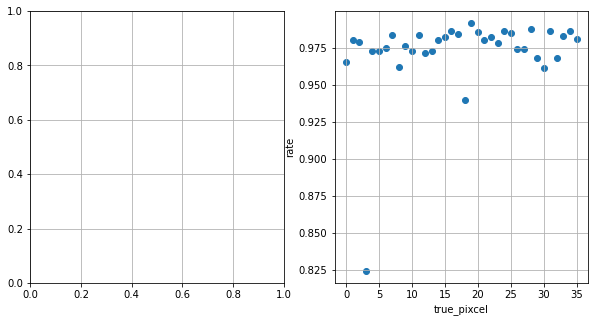

In [27]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
#ax[0].scatter(range(pixel_number),dic_pic_Ncla.values())
#ax[0].set_xlabel("true_pixcel")
#ax[0].set_ylabel("class")
ax[1].scatter(np.arange(36),rates)
ax[1].set_xlabel("true_pixcel")
ax[1].set_ylabel("rate")
ax[0].set_xticks
ax[0].grid()
ax[1].grid()

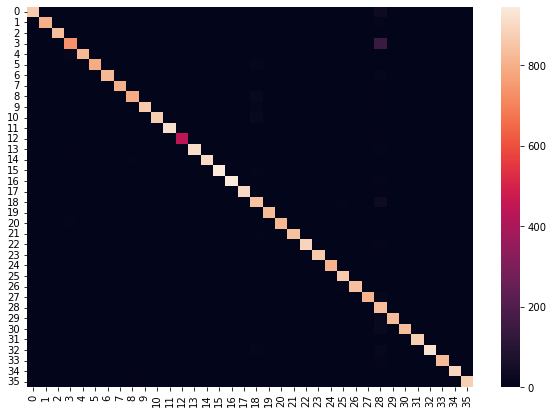

In [25]:
plt.figure(figsize = (10,7))
sns.heatmap(m)
plt.show()

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(m,norm=LogNorm())
plt.show()

In [ ]:
import numpy as np
import seaborn as sns; sns.set_theme(style='white')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

flights = m


f3, ax5 = plt.subplots(1,1)norm=LogNorm())
sns.heatmap(flights, square=True, 

In [ ]:
df_m = pd.DataFrame(m)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_m

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df_m.values,
         colLabels=df_m.columns,
         rowLabels=df_m.index,
         loc='center',
        )


# 教師なし学習

- MiniBatch Kmeans　で行った

In [96]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [97]:
df_data_Mini = pd.DataFrame(y,columns=["true_pixcel"])
df_data_Mini["data"] = list(data_df_pre.to_numpy())

#### MiniBatch KMeans >10,000

In [121]:
MiniB = MiniBatchKMeans(n_clusters=pixel_number,random_state=0)

MiniB.fit(X_pca_std)



MiniBatchKMeans(n_clusters=36, random_state=0)

In [122]:
df_data_Mini["clusters"]=MiniB.predict(X_pca_std)

## 結果　

<AxesSubplot:>

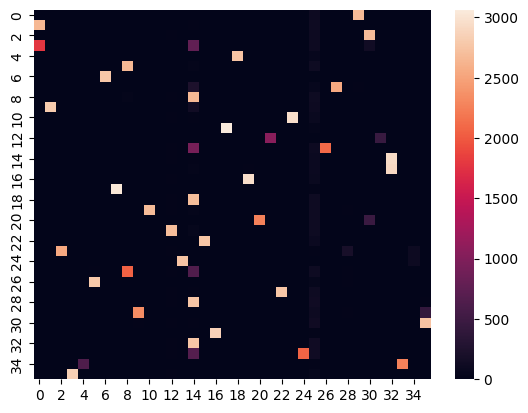

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

m = confusion_matrix(df_data_Mini["true_pixcel"],df_data_Mini["clusters"])
sns.heatmap(m)# x:cluster y:true

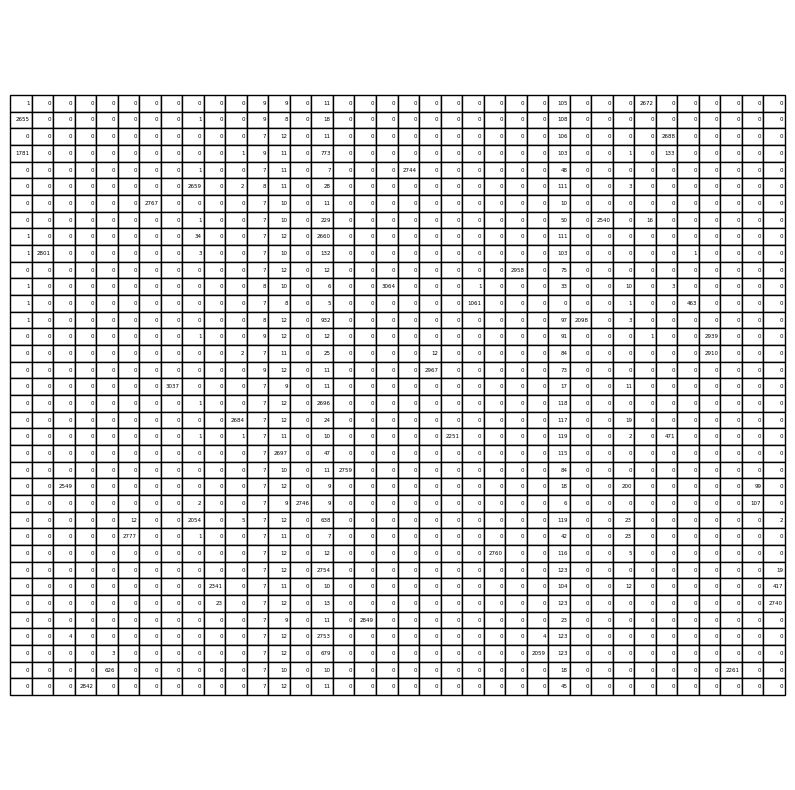

In [124]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=m,
         loc='center',
        )

In [125]:
df_data_Mini.groupby("true_pixcel").count()

data  clusters
true_pixcel                
0            2807      2807
1            2799      2799
2            2824      2824
3            2812      2812
4            2818      2818
5            2822      2822
6            2805      2805
7            2853      2853
8            2825      2825
9            3058      3058
10           3064      3064
11           3136      3136
12           1546      1546
13           3151      3151
14           3065      3065
15           3051      3051
16           3072      3072
17           3092      3092
18           2834      2834
19           2863      2863
20           2873      2873
21           2866      2866
22           2871      2871
23           2894      2894
24           2886      2886
25           2872      2872
26           2868      2868
27           2912      2912
28           2915      2915
29           2902      2902
30           2918      2918
31           2899      2899
32           2903      2903
33           2883      2883
34           2932      2932
35           2917      2917

In [126]:
cluster_names=[]
rates = []

for M in m:#Mはtrue_pixelに対するクラスタリング結果
    M = list(M)
    cluster_name = M.index(max(M))
    cluster_names.append(cluster_name) 
    rates.append(M[cluster_name]/sum(M))

In [127]:
cluster_names

[29,
 0,
 30,
 0,
 18,
 8,
 6,
 27,
 14,
 1,
 23,
 17,
 21,
 26,
 32,
 32,
 19,
 7,
 14,
 10,
 20,
 12,
 15,
 2,
 13,
 8,
 5,
 22,
 14,
 9,
 35,
 16,
 14,
 24,
 33,
 3]

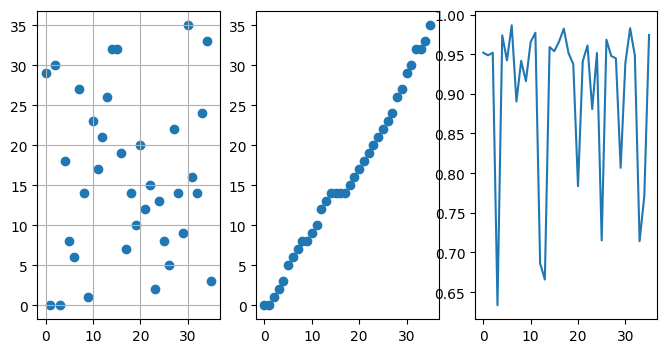

In [128]:
fig,ax = plt.subplots(1,3,figsize=(8,4))

ax[0].scatter(np.arange(36),cluster_names)
ax[1].scatter(np.arange(36),sorted(cluster_names))
ax[2].plot(np.arange(36),rates)
ax[0].grid()

In [129]:
dic_pic_Ncla = {}
dic_cla_Ncla = {}

for pixel,cluster in zip(range(pixel_number),cluster_names):
    
    if cluster not in dic_cla_Ncla.keys():
        dic_pic_Ncla[pixel] = pixel
        dic_cla_Ncla[cluster] = pixel
    else:
        dic_pic_Ncla[pixel] = dic_cla_Ncla[cluster]

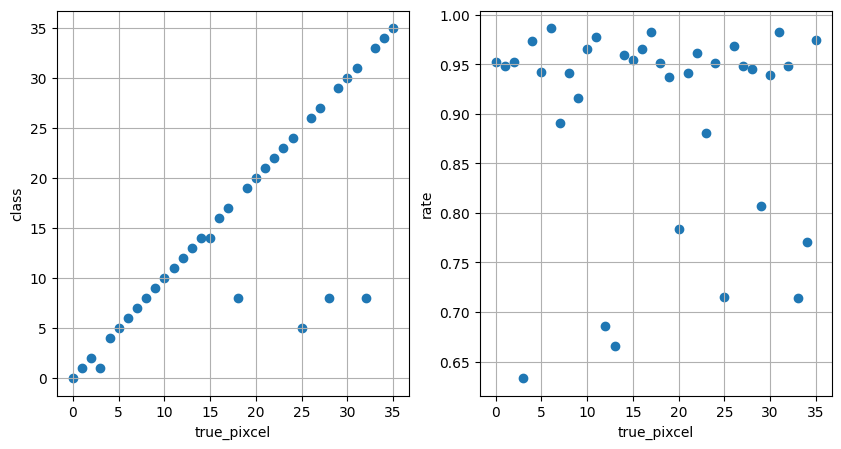

In [130]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(range(pixel_number),dic_pic_Ncla.values())
ax[0].set_xlabel("true_pixcel")
ax[0].set_ylabel("class")
ax[1].scatter(np.arange(36),rates)
ax[1].set_xlabel("true_pixcel")
ax[1].set_ylabel("rate")
ax[0].set_xticks
ax[0].grid()
ax[1].grid()

In [120]:
target = data_df_pre[data_df_pre.index.isin(df_data_Mini[df_data_Mini["clusters"]==2].index)]

In [89]:
from visualize import visualization as myvs

In [90]:
target_list = list(map(list,pd.DataFrame(df_data_Mini.groupby("clusters")["data"])[1]))#各クラスタの値をいれた三次元リスト

In [39]:
cluster_per_average = []
for d in target_list:
    D = np.array(d).mean(axis=0)
    cluster_per_average.append(D)


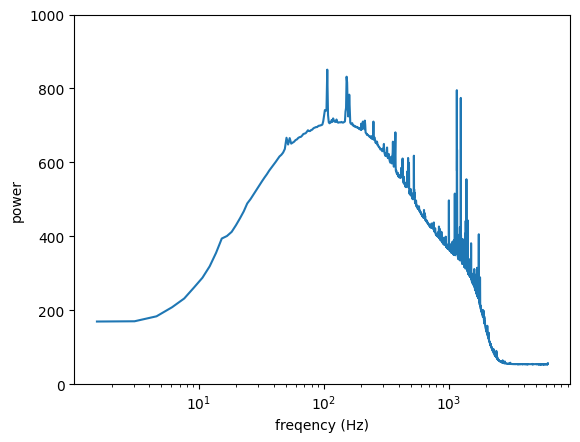

In [40]:
fig,ax = plt.subplots()

ax.plot(x,cluster_per_average[14])
ax.set_xlabel("freqency (Hz)")
ax.set_ylabel("power")
ax.set_ylim(0,1000)
ax.set_xscale("log")

#ax.set_yscale("log")

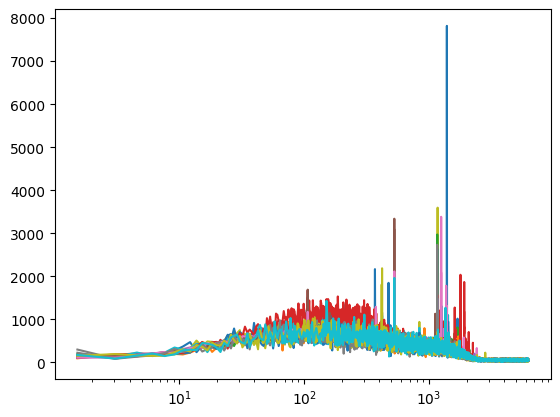

In [48]:
fig,ax = plt.subplots()
for i in range(20):
    ax.plot(x,target_list[14][i])
ax.set_xscale("log")

## true pixcel ごと

In [41]:
target_list_Tur = list(map(list,pd.DataFrame(df_data_Mini.groupby("true_pixcel")["data"])[1]))#各pixce;の値をいれた三次元リスト

In [42]:
np.array(target_list_Tur[18]).max()

27440.08561591478

In [44]:
cluster_per_average_tur = []
for d in target_list_Tur:
    D = np.array(d).mean(axis=0)
    cluster_per_average_tur.append(D)


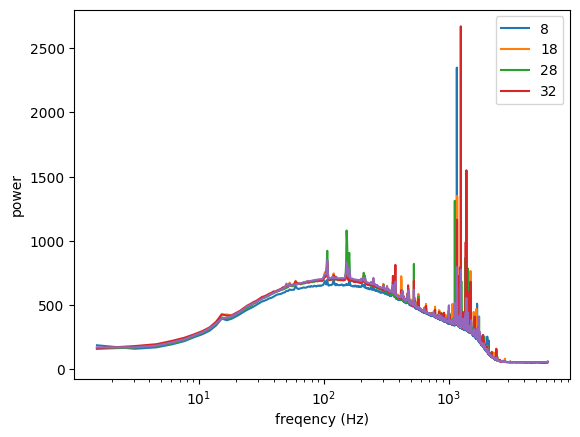

In [53]:
fig,ax = plt.subplots()
for pic in [8,18,28,32]:
    ax.plot(x,cluster_per_average_tur[pic],label=f"{pic}")
    
ax.plot(x,cluster_per_average[14])
ax.set_xlabel("freqency (Hz)")
ax.set_ylabel("power")
ax.set_xscale("log")
ax.legend()


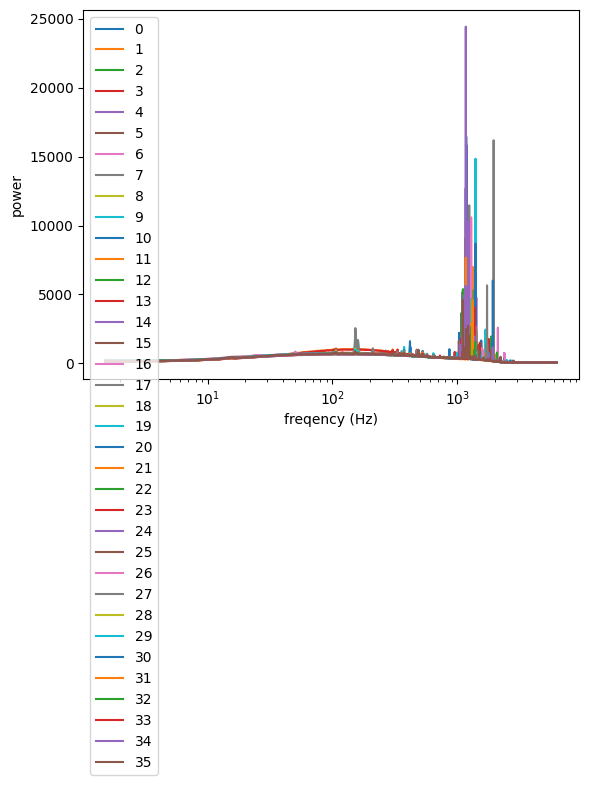

In [133]:
fig,ax = plt.subplots()
for pic in range(36):
    ax.plot(x,cluster_per_average_tur[pic],label=f"{pic}")
ax.set_xlabel("freqency (Hz)")
ax.set_ylabel("power")
ax.set_xscale("log")
ax.legend()

#### ARI：ランド計数は似たクラスタリングかどうかを判別する計数、ARIはランド計数を利用した値、１が最良、ランド計数についてはまた理解が足りない、似たものにNMIもある

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score #p186

adjusted_rand_score(df_data_Mini["true_pixel"],df_data_Mini["clusters"])